In [84]:
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt
import skimage

In [85]:
im_dir = "samples/duck.jpg"
img = cv2.imread(im_dir)
img = img.astype(np.float32)/255
channels = img.shape[-1]

In [86]:
def display_img(img,title=""):
    img_rgb = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2RGB)
    img_rgb = np.clip(img_rgb,a_min=0,a_max=1)
    plt.title(title)
    plt.imshow(img_rgb)

In [87]:
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

<h1>Base Image</h1>

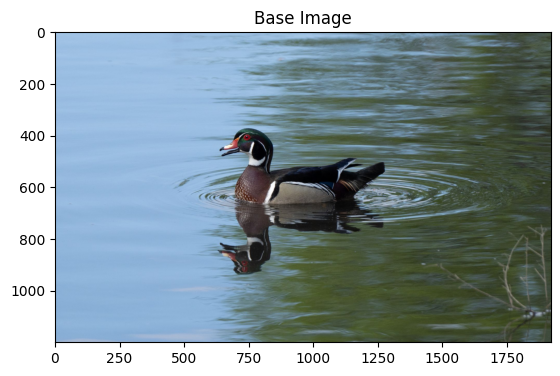

In [114]:
display_img(img, 'Base Image')

<h1>Noisy Image</h1>

In [89]:
mu = 0
sigma = 0.4
noise = np.random.normal(mu, sigma, size=img.shape)
img_noisy = img + noise

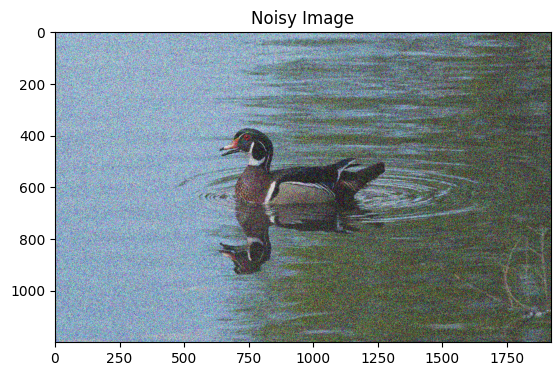

In [115]:
display_img(img_noisy, 'Noisy Image')

<h1>Noisy Image Denoised</h1>

In [91]:
img_denoised = skimage.restoration.denoise_wavelet(img_noisy, channel_axis=-1, convert2ycbcr=True, method='BayesShrink', mode='soft', rescale_sigma=True)

/Users/danze/.pyenv/versions/venv-445/lib/python3.12/site-packages/skimage/color/colorconv.py:754: RuntimeWarning: divide by zero encountered in matmul
  return arr @ matrix.T.astype(arr.dtype)
/Users/danze/.pyenv/versions/venv-445/lib/python3.12/site-packages/skimage/color/colorconv.py:754: RuntimeWarning: overflow encountered in matmul
  return arr @ matrix.T.astype(arr.dtype)
/Users/danze/.pyenv/versions/venv-445/lib/python3.12/site-packages/skimage/color/colorconv.py:754: RuntimeWarning: invalid value encountered in matmul
  return arr @ matrix.T.astype(arr.dtype)


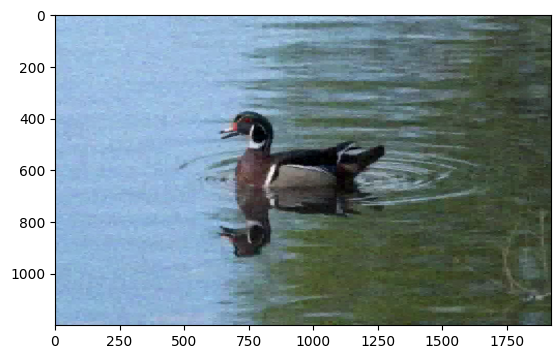

In [ ]:
display_img(img_denoised, 'Wavelet Denoised Image')

<h1>Blurred Image</h1>

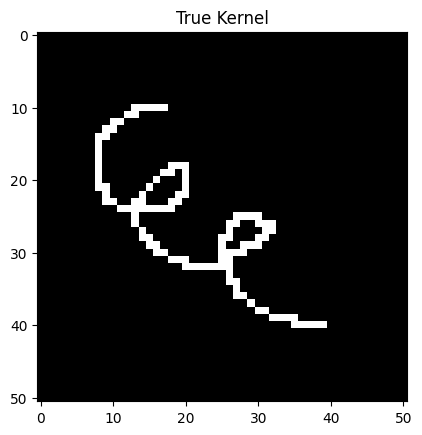

In [116]:
kernel_dir = "kernels/kernel_51x51.png"
kernel = cv2.imread(kernel_dir, cv2.IMREAD_GRAYSCALE)
kernel = kernel.astype(np.float32)/255
kernel = kernel/np.sum(kernel)
plt.title('True Kernel')
plt.imshow(kernel, cmap='gray')

In [94]:
img_blurry = np.stack([scipy.ndimage.convolve(img[:,:,i], kernel, mode='mirror') for i in range(channels)],axis=2)

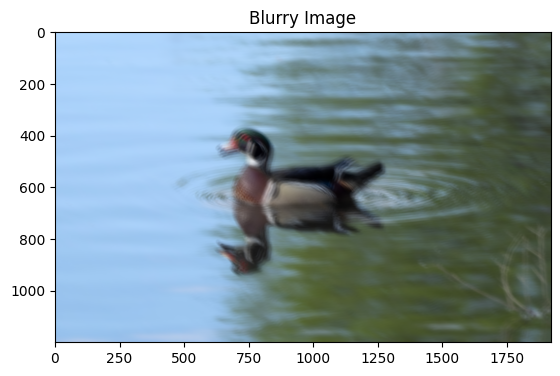

In [118]:
display_img(img_blurry, 'Blurry Image')

<h1>Kernel Estimation</h1>

In [96]:
b = img_blurry[350:850, 650:1150]
b = cv2.cvtColor(np.float32(b), cv2.COLOR_BGR2GRAY).flatten()
A = np.zeros((b.shape[0], (51*51)))
I = img_denoised[350:850, 650:1150]
I_pad = img_denoised[325:875,625:1175]
I_pad = cv2.cvtColor(np.float32(I_pad), cv2.COLOR_BGR2GRAY)
#I_pad = np.pad(I, ((25,25),(25,25)))
print(I_pad.shape)
print(A.shape)

(550, 550)
(250000, 2601)


In [97]:
for i in range(500):
    for j in range(500):
        conv_area = I_pad[i:i+51, j:j+51]
        A[i*I.shape[1]+j] = conv_area.flatten()

<h2>Least Squares Method</h2>

In [98]:
k_rec_lstsq = np.linalg.lstsq(A,b)

In [119]:
print(k_rec_lstsq[0].shape)
k_rec_lstsq_processed = k_rec_lstsq[0].copy()
k_rec_lstsq_processed[k_rec_lstsq_processed<0] = 0

(2601,)


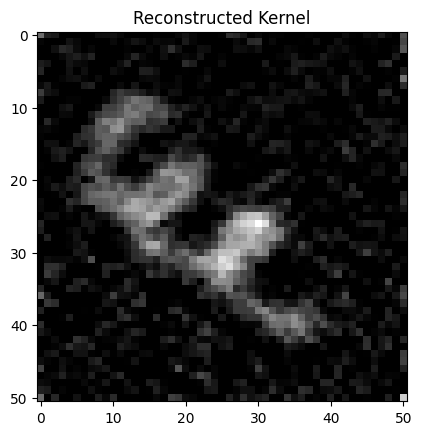

In [120]:
kernel_reconstructed = np.flip(k_rec_lstsq_processed.reshape((51,51)))
plt.title('Reconstructed Kernel')
plt.imshow(kernel_reconstructed, cmap='gray')

<h2>Landweber Method</h2>

In [18]:
b = img_blurry[350:850, 650:1150]
b = cv2.cvtColor(np.float32(b), cv2.COLOR_BGR2GRAY).flatten()
A = np.zeros((b.shape[0], (51*51)))
I = img_denoised[350:850, 650:1150]
I_pad = img_denoised[325:875,625:1175]
I_pad = cv2.cvtColor(np.float32(I_pad), cv2.COLOR_BGR2GRAY)
#I_pad = np.pad(I, ((25,25),(25,25)))
print(I_pad.shape)
print(A.shape)

(550, 550)
(250000, 2601)


In [19]:
for i in range(500):
    for j in range(500):
        conv_area = I_pad[i:i+51, j:j+51]
        A[i*I.shape[1]+j] = conv_area.flatten()

In [122]:
def landweber(A, b, beta=1.0, lamb=5.0):
    k = np.zeros(A.shape[1])
    k[0] = 1.0 # apply delta function
    print("Calculating ATb")
    ATb = A.T@b
    print("Calculating ATA with lambda")
    ATA_lambda = A.T@A + lamb**2 * np.eye(A.shape[1])
    print("Running iterative loop")
    for i in range(100):
        tmp = ATA_lambda@k
        # if i%10==0:
        #     print(ATb, tmp)
        k_next = k + beta * (ATb - tmp)
        k_next[k_next < 0] = 0
        k_sum = np.sum(k_next)
        # if (k_sum <= 0):
        #     k_next = np.zeros(A.shape[1])
        #     k_next[0] = 1.0
        # else:
        if k_sum > 0:
            k_next = k_next / k_sum
        convergence = np.linalg.norm(k_next - k)
        k = k_next.copy()
        if ((i%10)==0):
            print(convergence)
    return k

In [123]:
k_rec_landweber = landweber(A,b,lamb=0.0)

Calculating ATb


/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_2608/2949641106.py:5: RuntimeWarning: divide by zero encountered in matmul
  ATb = A.T@b
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_2608/2949641106.py:5: RuntimeWarning: overflow encountered in matmul
  ATb = A.T@b
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_2608/2949641106.py:5: RuntimeWarning: invalid value encountered in matmul
  ATb = A.T@b


Calculating ATA with lambda
Running iterative loop
1.004621119681068
0.04504546302919565
0.04452342372079889
0.04448096291424718
0.04447752200941226
0.04447723272679946
0.044477208336979185
0.04447720628062596
0.04447720610725073
0.04447720609263317


/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_2608/2949641106.py:7: RuntimeWarning: divide by zero encountered in matmul
  ATA_lambda = A.T@A + lamb**2 * np.eye(A.shape[1])
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_2608/2949641106.py:7: RuntimeWarning: overflow encountered in matmul
  ATA_lambda = A.T@A + lamb**2 * np.eye(A.shape[1])
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_2608/2949641106.py:7: RuntimeWarning: invalid value encountered in matmul
  ATA_lambda = A.T@A + lamb**2 * np.eye(A.shape[1])
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_2608/2949641106.py:10: RuntimeWarning: divide by zero encountered in matmul
  tmp = ATA_lambda@k
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_2608/2949641106.py:10: RuntimeWarning: overflow encountered in matmul
  tmp = ATA_lambda@k
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_2608/2949641106.py:10: RuntimeWarning: invalid value encountered in matmul
  tmp = A

(2601,)


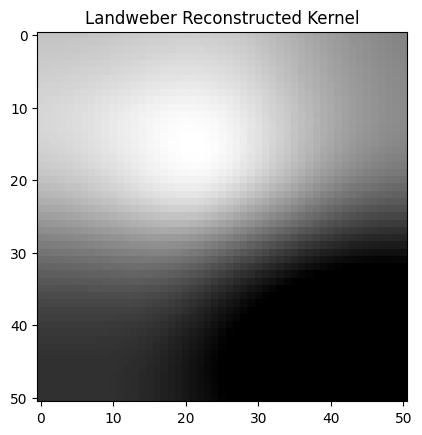

In [125]:
print(k_rec_landweber.shape)
plt.title('Landweber Reconstructed Kernel')
plt.imshow(k_rec_landweber.reshape((51,51)), cmap='gray')

## Residual Deconvolution

In [101]:
def rl_deconvolve(delta_b, K, I_0, num_iters=40):
    I = I_0
    for n in range(num_iters):
        den = np.stack([scipy.ndimage.convolve(I[:,:,i]+1,K, mode='mirror') for i in range(channels)],axis=2)
        tmp = np.stack([scipy.ndimage.correlate((delta_b[:,:,i]+1) / den[:,:,i],K, mode='mirror') for i in range(channels)],axis=2)
        I = tmp * (I+1) - 1

    return I

In [102]:
img_denoised_blurry = np.stack([scipy.ndimage.convolve(img_denoised[:,:,i], kernel_reconstructed, mode='mirror') for i in range(channels)],axis=2)

img_denoised_blurry = normalize(img_denoised_blurry)
img_blurry = normalize(img_blurry)

img_blurry_res = img_blurry - img_denoised_blurry

In [103]:
img_res = rl_deconvolve(img_blurry_res,kernel_reconstructed,img_denoised, num_iters=20)

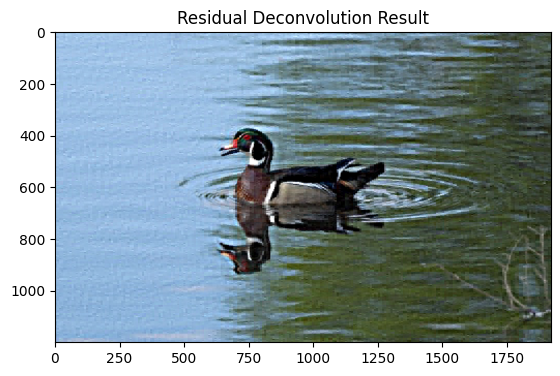

In [104]:
img_rl = img_denoised + img_res
display_img(img_rl, 'Residual Deconvolution Result')

## Gain-controlled RL

In [105]:
def generate_gain_map(Nd, alpha=0.2):
    gaussian_pyramid = tuple(skimage.transform.pyramid_gaussian(skimage.color.rgb2gray(Nd[:,:,[2,1,0]]), max_layer=-1, sigma=0.5))
    grad_sum = 0
    for l in range(len(gaussian_pyramid)):
        gh = skimage.filters.sobel_h(gaussian_pyramid[l])
        gv = skimage.filters.sobel_v(gaussian_pyramid[l])
        grad = np.sqrt(gh**2+gv**2)
        if l > 0:
            grad = cv2.resize(grad, (gaussian_pyramid[0].shape[1], gaussian_pyramid[0].shape[0]))
        
        grad_sum += grad

    grad_sum = (grad_sum - grad_sum.min()) / (grad_sum.max() - grad_sum.min())
    I_gain = (1-alpha) + alpha * grad_sum

    return I_gain

In [106]:
def gain_controlled_rl(delta_B, K, I_0, I_gain, num_iters=40):
    I = I_0

    for n in range(num_iters):
        den = np.stack([scipy.ndimage.convolve(I[:,:,i]+1,K, mode='mirror') for i in range(channels)],axis=2)
        tmp = np.stack([scipy.ndimage.correlate((delta_B[:,:,i]+1) / den[:,:,i], K, mode='mirror') for i in range(channels)],axis=2)
        I = I_gain[:,:,None] * (tmp * (I+1) - 1)
    
    return I

/Users/danze/.pyenv/versions/venv-445/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/danze/.pyenv/versions/venv-445/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/danze/.pyenv/versions/venv-445/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


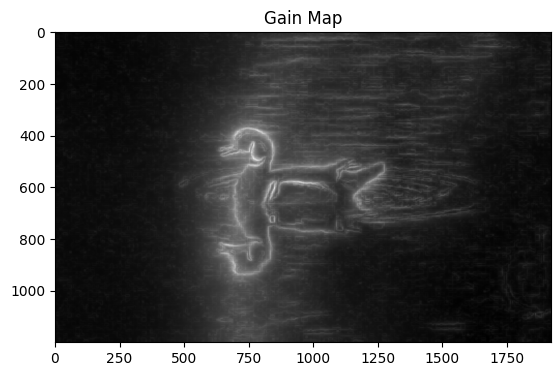

In [107]:
I_gain = generate_gain_map(img_denoised)
plt.title('Gain Map')
plt.imshow(I_gain,cmap='gray')

In [108]:
img_res_gain_controlled = gain_controlled_rl(img_blurry_res, kernel_reconstructed, img_denoised, I_gain, num_iters=20)

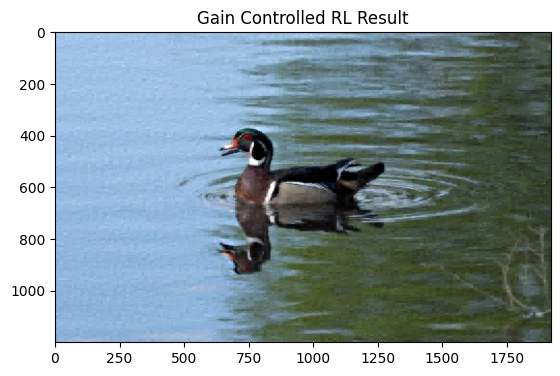

In [109]:
img_gain_controlled = img_denoised + img_res_gain_controlled
display_img(img_gain_controlled, 'Gain Controlled RL Result')

## Adding Detail

In [110]:
def joint_bilateral_filter(I, I_g, sigma_d=1.6, sigma_r=0.08, window=3):
    out = np.zeros_like(I)

    x, y = np.meshgrid(np.arange(-window, window+1), np.arange(-window, window+1))
    Gd = np.exp(-(x**2 + y**2) / (2 * sigma_d**2))

    for x in range(I.shape[0]):
        for y in range(I.shape[1]):
            x0 = max(0,x-window)
            x1 = min(I.shape[0],x+window+1)
            y0 = max(0,y-window)
            y1 = min(I.shape[1],y+window+1)

            sx0 = x0 - (x-window)
            sx1 = sx0 + (x1-x0)
            sy0 = y0 - (y-window)
            sy1 = sy0 + (y1-y0)

            Gr = np.exp(-np.sum((I_g[x,y]-I_g[x0:x1,y0:y1])**2,axis=2) / (2*sigma_r**2))
            W = Gd[sx0:sx1,sy0:sy1] * Gr
            W_sum = np.sum(W)

            out[x,y] = np.sum(W[:,:,None] * I[x0:x1,y0:y1],axis=(0,1)) / W_sum
    
    return out


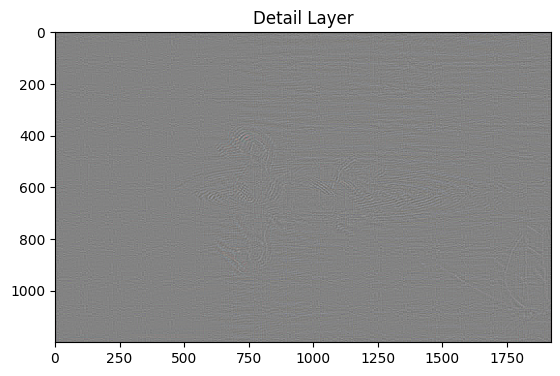

In [111]:
img_filtered = joint_bilateral_filter(img_rl, img_gain_controlled, sigma_r=0.1)
img_detail = img_rl - img_filtered
display_img(normalize(img_detail), 'Detail Layer')

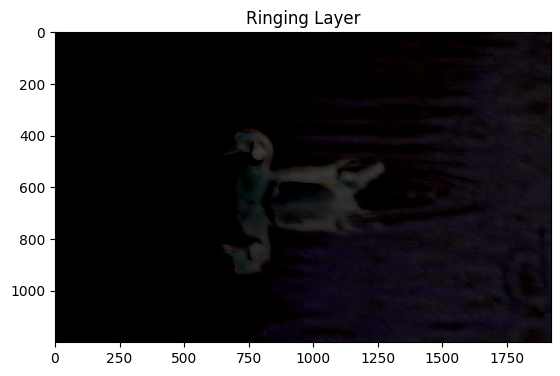

In [112]:
display_img(normalize(img_filtered)-img_gain_controlled, 'Ringing Layer')

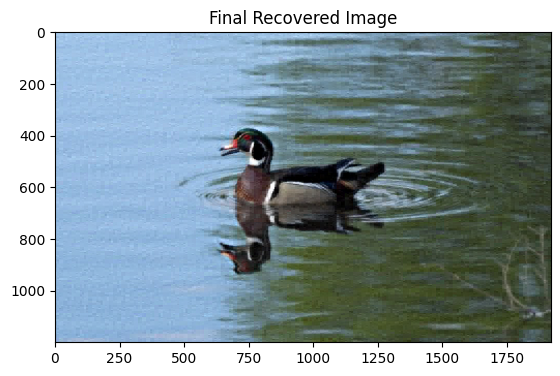

In [113]:
img_recovered = img_gain_controlled + img_detail
display_img(img_recovered, 'Final Recovered Image')